### Import

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from xgboost import plot_importance
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from itertools import combinations
from imblearn.over_sampling import SMOTE

### Data Load

In [2]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

### Data Preprocessing

In [3]:
X = train.drop(columns=['ID', 'Cancer'])
y = train['Cancer']

x_test = test.drop('ID', axis=1)

In [4]:
categorical_features = [col for col in X.columns if X[col].dtype == 'object']
for col in categorical_features:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    for val in np.unique(x_test[col]):
        if val not in le.classes_:
            le.classes_ = np.append(le.classes_, val)
    x_test[col] = le.transform(x_test[col])

### Train

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [6]:
def train_and_eval(X_tr, y_tr, X_val, y_val, label):
    model = XGBClassifier(random_state=42)
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_val)
    f1 = f1_score(y_val, y_pred)
    print(f"[{label}] Validation F1-score: {f1:.4f}")
    return model, f1

In [7]:
# (1) SMOTE 미적용
model_raw, f1_raw = train_and_eval(X_train, y_train, X_val, y_val, "RAW")

# (2) SMOTE 적용
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
model_smote, f1_smote = train_and_eval(X_train_smote, y_train_smote, X_val, y_val, "SMOTE")

[RAW] Validation F1-score: 0.2950
[SMOTE] Validation F1-score: 0.3311


In [35]:
T3_value = 2
T4_value = 11

X['Is_Hot_Nodule'] = (
    (X['TSH_Result'] < 0.4) & 
    (X['T3_Result'] > T3_value) & (X['T4_Result'] > T4_value)
).astype(int)

X['Rad_Child'] = (
    (X['Radiation_History'] == 1) & 
    (X['Age'] < 25)
).astype(int)


In [25]:
X

,Age,Gender,Country,Race,Family_Background,Radiation_History,Iodine_Deficiency,Smoke,Weight_Risk,Diabetes,Nodule_Size,TSH_Result,T4_Result,T3_Result,Is_Hot_Nodule,Rad_Child
0,80,1,1,1,1,0,1,0,0,0,0.650355,2.784735,6.744603,2.575820,0,0
1,37,1,7,1,1,1,1,1,1,0,2.950430,0.911624,7.303305,2.505317,0,0
2,71,1,1,4,1,1,1,0,0,1,2.200023,0.717754,11.137459,2.381080,0,0
3,40,0,4,3,0,1,1,0,1,0,3.370796,6.846380,10.175254,0.753023,0,0
4,53,0,1,2,0,1,1,0,0,0,4.230048,0.439519,7.194450,0.569356,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87154,65,0,4,1,1,1,1,0,0,0,0.510802,3.786859,4.838150,0.625754,0,0
87155,53,1,7,1,0,1,1,0,1,0,0.980413,4.335395,8.937716,2.728584,0,0
87156,29,0,8,2,0,1,1,0,0,0,0.180998,5.724924,4.847265,3.318609,0,0
87157,52,0,4,1,1,1,1,0,0,0,2.420773,4.978069,10.867191,2.259199,0,0


In [31]:
X['Is_Hot_Nodule'].value_counts()

Is_Hot_Nodule
0    86999
1      160
Name: count, dtype: int64

Test F1 Score: 0.3301


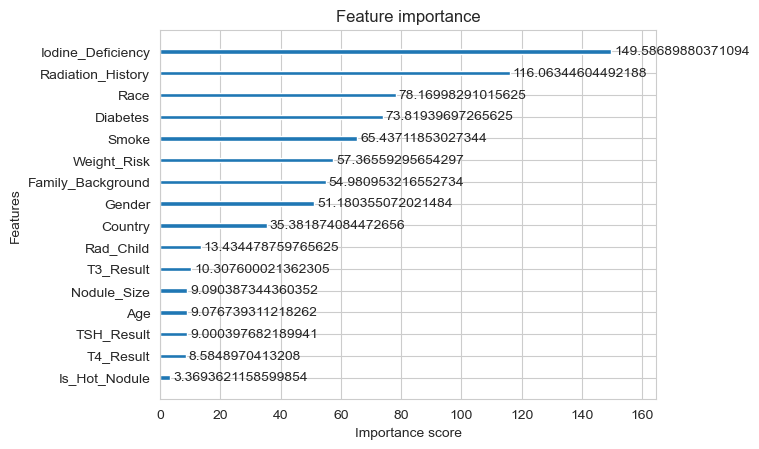

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# SMOTE는 train에만 적용
X_train_sm, y_train_sm = SMOTE(random_state=42).fit_resample(X_train, y_train)

# 최종 모델 학습
final_model = XGBClassifier(random_state=42)
final_model.fit(X_train_sm, y_train_sm)

importance = final_model.feature_importances_

# 시각화
plot_importance(final_model, importance_type='gain')

y_pred = final_model.predict(X_test)
print(f"Test F1 Score: {f1_score(y_test, y_pred):.4f}")


### Predict

In [18]:
def interaction_model_selection(X, y, base_model=None, scoring='roc_auc', cv_folds=5, overfit_penalty=True):
    if base_model is None:
        base_model = XGBClassifier(eval_metric='logloss', verbosity=0)

    best_score = -np.inf
    best_combo = None
    best_X = X.copy()
    original_cols = X.columns
    results = []

    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

    for combo in combinations(original_cols, 2):
        col_name = f"{combo[0]}_x_{combo[1]}"
        X_new = X.copy()
        X_new[col_name] = X[combo[0]] * X[combo[1]]

        scores = cross_val_score(base_model, X_new, y, cv=skf, scoring=scoring)
        mean_score = scores.mean()
        std_score = scores.std()

        # 점수에서 표준편차를 빼서 과적합 위험 감안
        penalized_score = mean_score - std_score if overfit_penalty else mean_score

        results.append((combo, col_name, mean_score, std_score, penalized_score))

        if penalized_score > best_score:
            best_score = penalized_score
            best_combo = combo
            best_X = X_new

    print(f"✅ Best interaction: {best_combo}, Penalized Score = {best_score:.4f}")
    df_results = pd.DataFrame(results, columns=["Combo", "FeatureName", "CV_Mean", "CV_Std", "PenalizedScore"])
    df_results.sort_values(by="PenalizedScore", ascending=False, inplace=True)

    return best_X, df_results

def add_interaction_features(X, combos):
    X_new = X.copy()
    for (f1, f2) in combos:
        X_new[f"{f1}_x_{f2}"] = X[f1] * X[f2]
    return X_new

In [19]:
X_best, result_df = interaction_model_selection(X_final, y_final)

✅ Best interaction: ('Age', 'Country'), Penalized Score = 0.8800


In [21]:
result_df

,Combo,FeatureName,CV_Mean,CV_Std,PenalizedScore
1,"(Age, Country)",Age_x_Country,0.881761,0.001788,0.879974
5,"(Age, Iodine_Deficiency)",Age_x_Iodine_Deficiency,0.881462,0.001618,0.879843
34,"(Country, T4_Result)",Country_x_T4_Result,0.880332,0.001282,0.879051
28,"(Country, Iodine_Deficiency)",Country_x_Iodine_Deficiency,0.880130,0.001199,0.878931
2,"(Age, Race)",Age_x_Race,0.880716,0.001791,0.878926
...,...,...,...,...,...
90,"(T4_Result, T3_Result)",T4_Result_x_T3_Result,0.878263,0.001457,0.876806
21,"(Gender, Nodule_Size)",Gender_x_Nodule_Size,0.878661,0.001902,0.876759
82,"(Diabetes, TSH_Result)",Diabetes_x_TSH_Result,0.878731,0.002045,0.876686
53,"(Family_Background, T4_Result)",Family_Background_x_T4_Result,0.878531,0.001859,0.876672


In [22]:
best_combo = result_df.sort_values(by='PenalizedScore', ascending=False).iloc[0]['Combo']

# 2. train/test 모두 동일하게 interaction 추가
X_train_best = add_interaction_features(X_final, [best_combo])
X_test_best = add_interaction_features(x_test, [best_combo])

# 3. 모델 학습 및 예측
model = XGBClassifier(eval_metric='logloss')
model.fit(X_train_best, y_final)
y_pred = model.predict(X_test_best)

In [ ]:
#final_pred = final_model.predict(X_best)

### Submission

In [23]:
submission = pd.read_csv('sample_submission.csv')

In [24]:
submission['Cancer'] = y_pred

In [26]:
submission.to_csv('interaction_submit2.csv', index=False)